# **Library**

In [33]:
import tensorflow as tf
import keras 
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array

# **Data**

In [34]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 128
_img = []
path = '../content/Facemask Dataset 20,000 Images/new_without_mask'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
        if i == 'seed9090.png':
            break
        else:    
            img = cv2.imread(path + '/'+i,1)
            # open cv reads images in BGR format so we have to convert it to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #resizing image
            img = cv2.resize(img, (SIZE, SIZE))
            img = (img - 127.5) / 127.5
            imh = img.astype(float)
            _img.append(img_to_array(img))

 91%|█████████ | 9090/10000 [00:18<00:01, 496.14it/s]


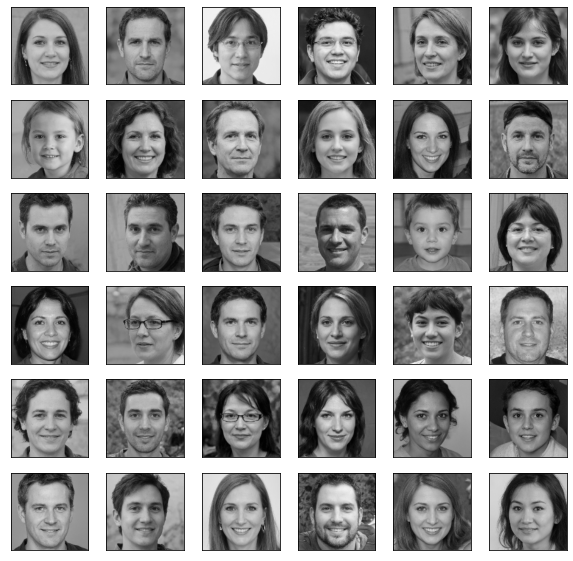

In [35]:
def plot_images(sqr = 5):
    plt.figure(figsize = (10,10))
    plt.title("Real Images",fontsize = 35)
    for i in range(sqr * sqr):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])

# to plot images
plot_images(6)

In [36]:
batch_size = 32
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

# **Generator**

In [37]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128*128*3, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.Reshape((128,128,3)))
    # downsampling
    model.add(tf.keras.layers.Conv2D(128,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=1, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    
    model.add(tf.keras.layers.LeakyReLU())
    #upsampling
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(512, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=1,padding='same',kernel_initializer='he_normal',use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2DTranspose(3,4,strides = 1, padding = 'same',activation = 'tanh'))
    
    

    return model

In [38]:
generator = Generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 49152)             4915200   
                                                                 
 reshape_1 (Reshape)         (None, 128, 128, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 128)     6144      
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       262144    
                                                                 
 batch_normalization_9 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                      

# **Discriminator**

In [39]:
def Discriminator():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [40]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       6144      
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       262144    
                                                                 
 batch_normalization_15 (Bat  (None, 32, 32, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 128)      

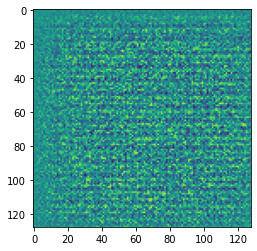

In [41]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

Fungsi Loss dan Fungsi Optimimalisasi

In [42]:
optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [43]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [44]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)
        
        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)
        
        
    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)    
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)
    
    optimizer.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))
    
    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss

In [45]:
def plot_generated_images(square = 5, epochs = 0):
    
    
  plt.figure(figsize = (10,10))
  for i in range(square * square):
    if epochs != 0:    
        if(i == square //2):
            plt.title("Generated Image at Epoch:{}\n".format(epochs), fontsize = 32, color = 'black')
    plt.subplot(square, square, i+1)
    noise = np.random.normal(0,1,(1,latent_dim))
    img = generator(noise)
    plt.imshow(np.clip((img[0,...]+1)/2, 0, 1))
    
    plt.xticks([])
    plt.yticks([])
    plt.grid()

In [46]:
import time
def train(epochs,dataset):
    
    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2)) 
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

# **Training**

In [49]:
train(5,dataset)
# i had train model previously for more than 10 epochs so generated images are quiet good


Epoch : 1


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


KeyboardInterrupt: ignored

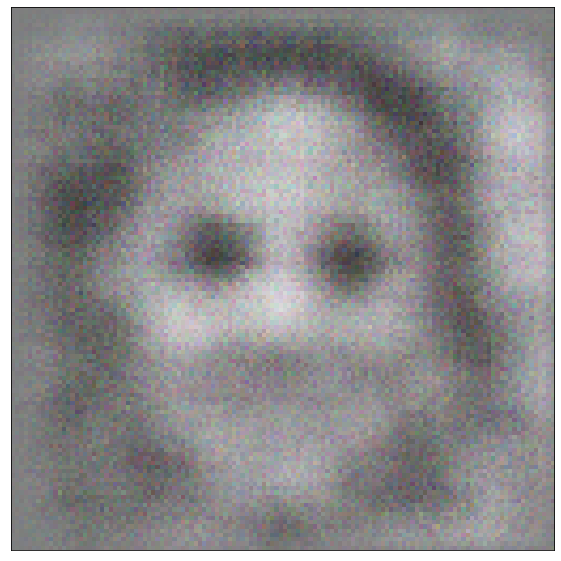

In [50]:
plot_generated_images(1)

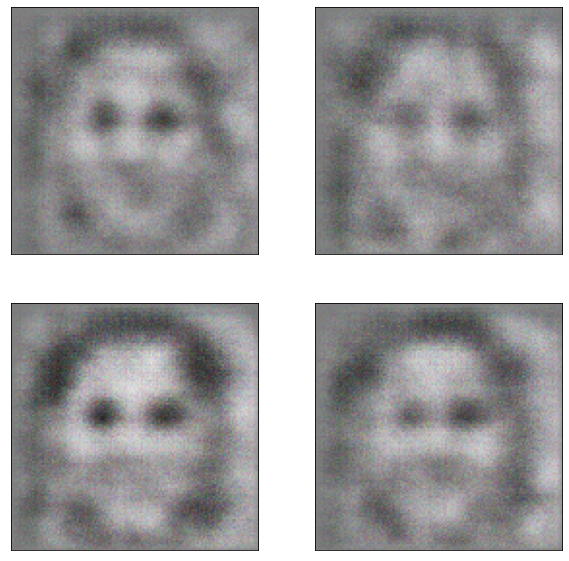

In [51]:
plot_generated_images(2)

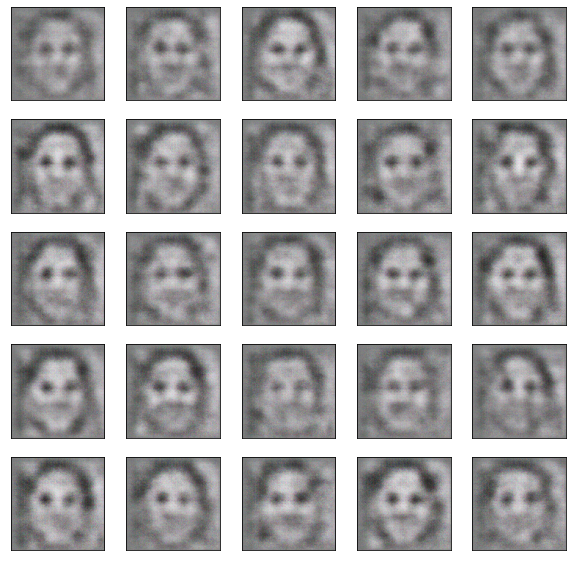

In [52]:
plot_generated_images(5)

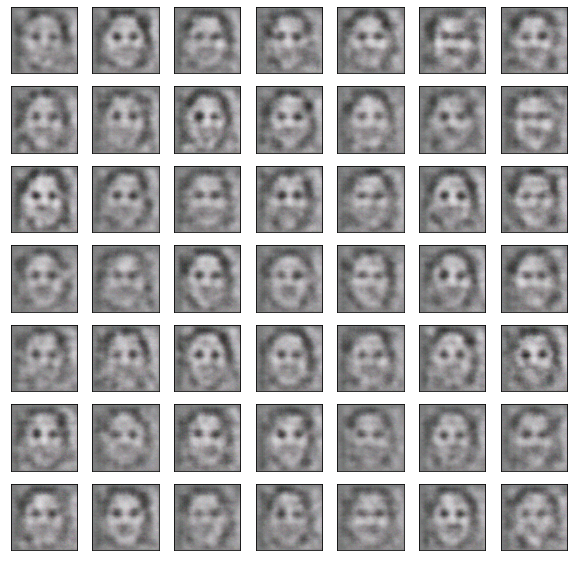

In [53]:
plot_generated_images(7)

In [ ]:
generator.save('generator.h5')
discriminator.save("discriminator.h5")